In [49]:
Path('utils').mkdir(parents=True,exist_ok=True)

In [50]:
%%writefile utils/download_data.py

import os
import zipfile
import requests
from pathlib import Path

def download_data():
  data_path = Path("data")
  image_path = data_path/"league_dataset"

  if not image_path.is_dir():
    image_path.mkdir(parents=True,exist_ok = True)

    with open(data_path/"league_dataset.zip","wb") as f:
      request = requests.get("https://github.com/HatemSal/LOL_Champ_Classifier/raw/refs/heads/main/league_dataset.zip")
      f.write(request.content)

    with zipfile.ZipFile(data_path/"league_dataset.zip",'r') as zip_ref:
      zip_ref.extractall(image_path)
  dataset_path = image_path/"league_dataset"
  return dataset_path

Writing utils/download_data.py


In [53]:
from utils import download_data
from download_data import download_data
dataset_path = download_data()
train_dir = dataset_path/"train"
test_dir=dataset_path/'test'
dataset_path

PosixPath('data/league_dataset/league_dataset')

In [3]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms, models
weights = models.ViT_B_16_Weights.DEFAULT
model = models.vit_b_16(weights=weights)
data_transform = weights.transforms()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 60.3MB/s]


Dataset ImageFolder
    Number of datapoints: 90
    Root location: data/league_dataset/league_dataset/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [52]:
%%writefile utils/data_setup.py
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets

def create_train_dataloader(train_dir,transform,batch_size):
  train_dataset = datasets.ImageFolder(root=train_dir,transform=transform,target_transform=None)
  class_dict = train_dataset.class_to_idx
  class_names = train_dataset.classes
  train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
  return train_dataloader, class_names, class_dict

Writing utils/data_setup.py


In [54]:
from utils import data_setup
from data_setup import create_train_dataloader
train_dataloader, class_names, class_dict = create_train_dataloader(train_dir = train_dir,transform=data_transform,batch_size=30)
train_dataloader

In [55]:
next(iter(train_dataloader))[0].shape

torch.Size([30, 3, 224, 224])

In [7]:
try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

In [8]:
summary(model=model,
        input_size=(1,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

In [9]:
for param in model.parameters():
  param.requires_grad =False

model.heads = nn.Linear(in_features=768,out_features=3)
summary(model=model,
        input_size=(1,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [51]:
%%writefile utils/engine.py
from tqdm.auto import tqdm
import torch
from torch import nn

def train_model(model,train_dataloader,loss_fn,optimizer,EPOCHS):
  for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n------------")
    model.train()
    train_loss =0
    train_acc=0
    for X, y in train_dataloader:
      X, y = X.to(device), y.to(device)
      y_logits = model(X)
      loss = loss_fn(y_logits,y)
      train_loss +=loss
      y_preds = y_logits.argmax(dim=1)
      train_acc += ((y_preds==y).sum())/len(y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Train Loss: {train_loss} | Train Acc: {train_acc}")

Writing utils/engine.py


In [ ]:
from utils import engine
from engine import train_model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.003,weight_decay=0.3)

train_model(model=model,train_dataloader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,EPOCHS=5)

In [15]:
with open("panth.jpg" ,'wb') as f:
  request = requests.get("https://gamingonphone.com/wp-content/uploads/2021/03/Pantheon-Wild-Rift.jpg")
  f.write(request.content)

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open("panth.jpg")
img_transformed = data_transform(img)
img_transformed.shape

torch.Size([3, 224, 224])

In [26]:
from PIL import Image
import matplotlib.pyplot as plt
def pred_and_plot_img(model,image_path,class_names,transform):
  model.eval()
  img = Image.open(image_path)
  img_transformed = transform(img).to(device)
  y_logit = model(img_transformed.unsqueeze(dim=0))
  y_label = y_logit.argmax(dim=1)
  y_class = class_names[y_label]
  plt.imshow(img)
  plt.title(f"Predicted class: {y_class}")
  plt.axis(False)


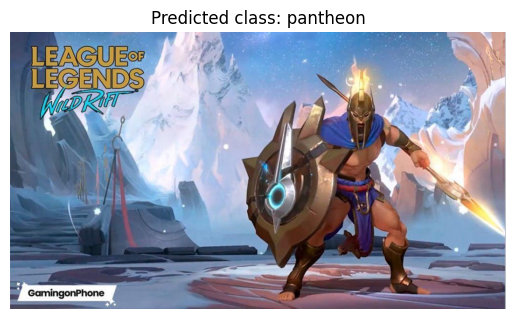

In [27]:
pred_and_plot_img(model=model,image_path="panth.jpg",class_names=class_names,transform=data_transform)

(-0.5, 299.5, 167.5, -0.5)

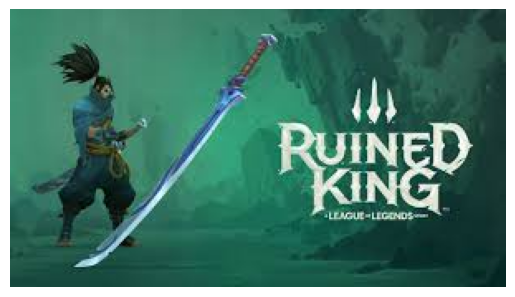

In [35]:
with open("yasuo.jpg",'wb') as f:
  request = requests.get('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTMZKz9VZuiopu5-rzShhhCdVSugLj9HhFdDg&s')
  f.write(request.content)
img = Image.open('yasuo.jpg')
plt.imshow(img)
plt.axis(False)

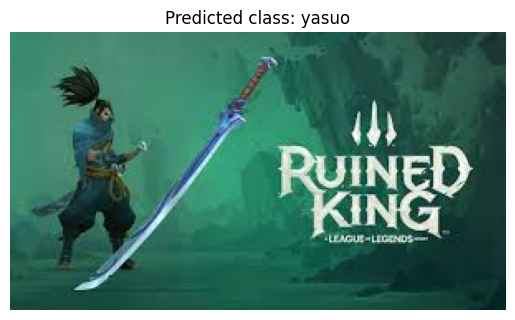

In [36]:
pred_and_plot_img(model=model,image_path='yasuo.jpg',class_names=class_names,
                  transform=data_transform)

In [56]:
Path('models').mkdir(parents=True,exist_ok=True)
torch.save(model.state_dict(),"models/LOL_model_v1_3_champs.pth")

In [57]:
from google.colab import files
!zip -r utils.zip utils  # Replace 'my_folder' with the actual folder name
files.download('utils.zip')

  adding: utils/ (stored 0%)
  adding: utils/data_setup.py (deflated 55%)
  adding: utils/download_data.py (deflated 50%)
  adding: utils/engine.py (deflated 54%)
  adding: utils/__pycache__/ (stored 0%)
  adding: utils/__pycache__/download_data.cpython-311.pyc (deflated 42%)
  adding: utils/__pycache__/data_setup.cpython-311.pyc (deflated 34%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
new_weights = models.ViT_B_16_Weights.DEFAULT
new_model = models.vit_b_16(weights=weights)
new_model.heads = nn.Linear(in_features=768,out_features=3)
new_model.load_state_dict(torch.load('models/LOL_model_v1_3_champs.pth'))

<ipython-input-59-46a1b6858a7a>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('models/LOL_model_v1_3_champs.pth'))


<All keys matched successfully>

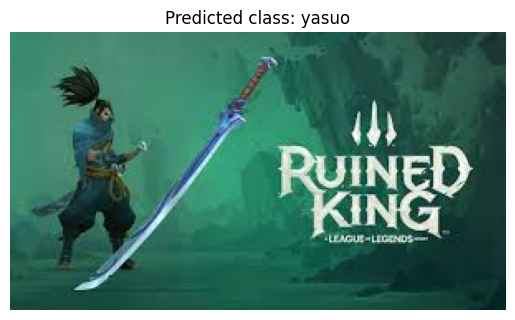

In [61]:
pred_and_plot_img(new_model.to(device),'yasuo.jpg',class_names,data_transform)